# Hate Speech Classification using 1D CNN with Tensorflow

### Task 1: Import Packages and Functions

In [3]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
plt.style.use('fivethirtyeight')
print(tf.__version__)

2.2.0


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Task 2: Load and Explore Data

In [4]:
# Load data
train_df = pd.read_csv('data/toxic_train.csv')

In [5]:
train_df.sample(10,random_state=1)

,Unnamed: 0,comment_text,toxic
24915,24915,"YOU ARE A FAT, GEEKY PRICK WHO HAS NOTHING TO ...",1
75819,75819,Agent X2: Basically thanks - with a 'little' m...,0
53891,53891,Why are my posts being deleted? \n\nI have tri...,0
154159,154159,"""\n\n Controlled Demolitions and Common Sense ...",0
13040,13040,I do not understand your reply. //Blaxthos ( ...,0
123190,123190,Is this the bizarro world? Removing content is...,0
33626,33626,"Well, WP:RS says that articles should use reli...",0
1150,1150,Oh hear me go someone removes all my pages i g...,0
48633,48633,can't believe this article was deleted\nI'm su...,0
42817,42817,"""\n\n Comments on GamerGate Workshop page \n\n...",0


In [6]:
x = train_df['comment_text']
y = train_df['toxic']

In [76]:
# View some toxic comments
train_df[train_df.toxic==1].sample(5)

,Unnamed: 0,comment_text,toxic
26311,26311,"In the time it took me to add this, Mifter and...",1
130663,130663,NONE OF THIS MP STUFF IS TRUE AND I HEARD TODA...,1
33867,33867,Are you from AGN? The sucky site?,1
22386,22386,"loser, stop harassing me",1
119300,119300,And this meat puppet would be whom? Tim Foxworth,1


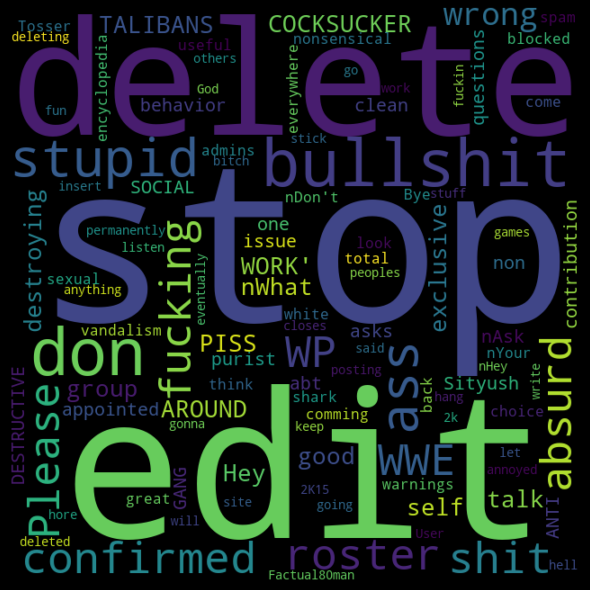

In [8]:
comments = train_df['comment_text'].loc[train_df['toxic']==1].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(comments))
fig = plt.figure(
    figsize = (12, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

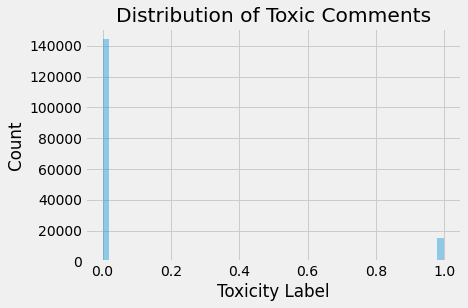

In [9]:
# Plot frequency of toxic comments
fig = sns.distplot(train_df['toxic'], kde=False)
plt.xlabel("Toxicity Label")
plt.ylabel("Count")
plt.title("Distribution of Toxic Comments")
plt.show(fig)

In [10]:
train_df['toxic'].value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

### Task 3: Data Prep — Tokenize and Pad Text Data

In [11]:
max_features = 20000
max_text_length = 400

In [12]:
x_tokenizer = text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list(x))

In [13]:
# Save tokenizer for future use
with open('toxic_tokenizer.pkl', 'wb') as f:
    pickle.dump(x_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
x_tokenized = x_tokenizer.texts_to_sequences(x)
x_train_val= sequence.pad_sequences(x_tokenized, maxlen=max_text_length)

### Task 4: Prepare Embedding Matrix with Pre-trained GloVe Embeddings

In [15]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip

In [16]:
embedding_dim =100
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embeddings_index[word]= coefs
f.close()
print(f'Found {len(embeddings_index)} word vectors')

Found 400000 word vectors


In [17]:
embedding_matrix= np.zeros((max_features,embedding_dim))
for word, index in x_tokenizer.word_index.items():
    if index>max_features-1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index]= embedding_vector

### Task 5: Build the Model

In [18]:
filters= 250
kernel_size=3
hidden_dims= 250

In [19]:
model = Sequential()
model.add(Embedding(max_features,
                    embedding_dim,
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False))
model.add(Dropout(0.2))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(filters,
                 5,
                 padding='valid',
                 activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         2000000   
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 250)         75250     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 250)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 250)         312750    
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 250)               6

### Task 6: Compile Model

In [52]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

### Task 7: Splitting the data into training and validation set

In [53]:
x_train,x_val,y_train,y_val = train_test_split(x_train_val,y,test_size=0.3,random_state=1)

### Task 8: Model Fitting/Training

In [54]:
batch_size= 32
epochs = 3
hist = model.fit(x_train,y_train,
                    batch_size= batch_size,
                    epochs=epochs,
                    validation_data= (x_val,y_val)
                    )

Epoch 1/3
3491/3491 [==============================] - 79s 23ms/step - loss: 0.0831 - accuracy: 0.9690 - val_loss: 0.1356 - val_accuracy: 0.9570
Epoch 2/3
3491/3491 [==============================] - 79s 23ms/step - loss: 0.0769 - accuracy: 0.9705 - val_loss: 0.1197 - val_accuracy: 0.9569
Epoch 3/3
3491/3491 [==============================] - 78s 22ms/step - loss: 0.0714 - accuracy: 0.9725 - val_loss: 0.1201 - val_accuracy: 0.9581


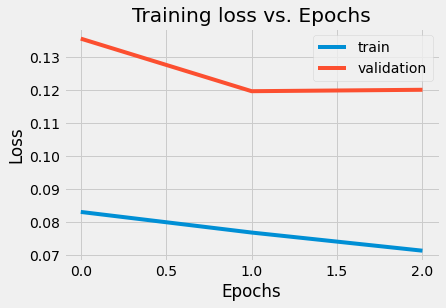

In [55]:
# Plot loss
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss vs. Epochs')
plt.legend()
plt.show()

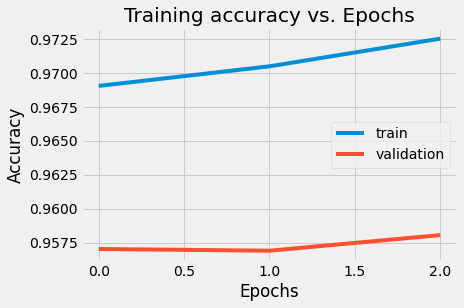

In [56]:
# Plot accuracy
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs. Epochs')
plt.legend()
plt.show()

### Task 9: Evaluate Model

In [57]:
test_df = pd.read_csv('data/toxic_test.csv')

In [58]:
x_test = test_df['comment_text'].values
y_test = test_df['toxic'].values

In [59]:
x_test_tokenized = x_tokenizer.texts_to_sequences(x_test)
x_testing = sequence.pad_sequences(x_test_tokenized,maxlen=max_text_length)

In [60]:
y_pred = model.predict(x_testing,verbose=1,batch_size=32)

2000/2000 [==============================] - 16s 8ms/step


In [61]:
y_pred = [0 if y[0] < 0.5 else 1 for y in y_pred]

In [62]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))

Accuracy: 92.64%


In [63]:
print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred, average='macro')))

F1 Score: 0.811030


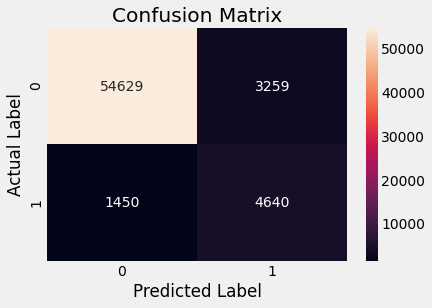

In [64]:
cm = confusion_matrix(y_test, y_pred)
fig = sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show(fig)

### Extras: View our results!

In [65]:
test_df['prediction'] = [ 'not toxic' if y == 0 else 'toxic' for y in y_pred]

In [66]:
test_df.head(20)

,Unnamed: 0,comment_text,toxic,prediction
0,5,Thank you for understanding. I think very high...,0,not toxic
1,7,:Dear god this site is horrible.,0,not toxic
2,11,"""::: Somebody will invariably try to add Relig...",0,not toxic
3,13,""" \n\n It says it right there that it IS a typ...",0,not toxic
4,14,""" \n\n == Before adding a new product to the l...",0,not toxic
5,16,this other one from 1897,0,not toxic
6,17,== Reason for banning throwing == \n\n This ar...,0,not toxic
7,19,|blocked]] from editing Wikipedia. |,0,not toxic
8,21,"== Arabs are committing genocide in Iraq, but ...",1,toxic
9,22,Please stop. If you continue to vandalize Wiki...,0,not toxic


### Task 10: Save our model for future use

In [67]:
model.save('toxic_cnn.h5')